In [1]:
%matplotlib inline
import dm as diffusion_maps
import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import subsample as sb
plt.style.use('seaborn-white')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rcParams['image.cmap'] = 'Spectral'

import seaborn as sns

In [2]:
import DiffusionMaps as reg
from sklearn import neighbors

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.spatial.distance import cdist, pdist

## Subsystem One keff ~k1

In [4]:
def midlevel_MEK_ERK_model(x, t, k1, k2, k3):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    dS0  = -k1*x[0]*x[3] + k2*x[1]
    dES0 =  k1*x[0]*x[3] - k2*x[1] - k3*x[1]
    dS1  =  k3*x[1] 
    dE   = -k1*x[3]*x[0] + k2*x[1] + k3*x[1] 
    
    return [dS0, dES0, dS1, dE]

In [5]:
use_S2_only = True
generator = np.random.RandomState(1)

num_samples = 2000
num_steps = 6
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 10, num_steps + 1)
delta_k = 0.10 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size-1))
observations = np.zeros((num_samples, (1 if use_S2_only else 4)*num_steps-1)) # data to be used for DMaps

# Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.71, 19, 6700])
for i in tqdm.trange(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size -1)
    sol = odeint(midlevel_MEK_ERK_model, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[2:,2]
    else:
        observations[i,:] = sol[1:,:].reshape(1,-1)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
Combined_Subsystem1 = np.c_[rate_constants, observations]

In [9]:
pw_dists = pdist(observations, "euclidean")
eps_par_red = 0.04*np.median(pw_dists**2) # scale parameter
dmap_par_red = diffusion_maps.SparseDiffusionMaps(points = observations,
                                                  epsilon = eps_par_red,
                                                  num_eigenpairs = 15,
                                                  cut_off = np.inf,  
                                                  renormalization = 1,
                                                  normalize_kernel = True)
phi1 = dmap_par_red.eigenvectors.T # dominant eigenvectors, including the trivial one

Subsampling points.
Considering min_distance 0.050000.
Subsampling complete, taking 105 out of 2000 points.
Calculating 13 residuals


Calculating 13 residuals:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

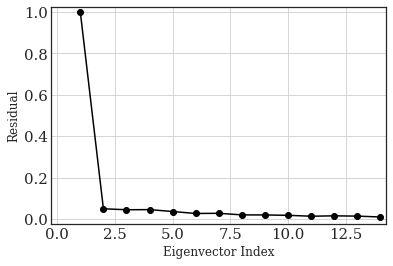

In [10]:
(subsampled_phi, idx_phi) = sb.subsample(phi1 , min_distance = 0.05)
residuals = reg.DiffusionMap.compute_residuals(subsampled_phi, eps_scale = 3.0)["Residuals"]
indices = np.where(residuals > 0.4)[0] # indices of non-harmonic eigenvectors

fig_residuals = plt.figure(figsize = (6, 4))
ax = fig_residuals.add_subplot(111)
ax.plot(range(1, subsampled_phi.shape[1]), residuals[1:], "ko-")
ax.set_xlim(-0.25, subsampled_phi.shape[1] - 0.75)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel("Eigenvector Index", fontsize = 12)
ax.set_ylabel("Residual", fontsize = 12)
ax.grid(True)

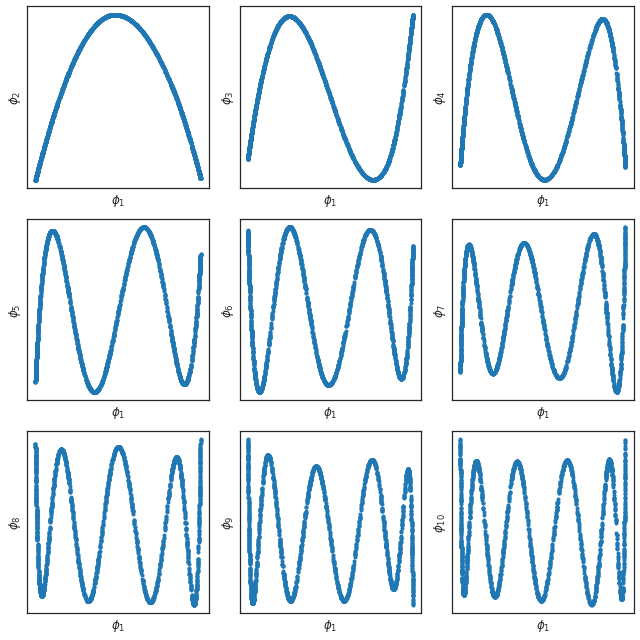

In [21]:
fig_dmaps_evecs = plt.figure(figsize = (3*3, 3*3));
for i in range (2,11):
    #fmt = "go" if i in indices else "bo"
    ax = fig_dmaps_evecs.add_subplot(3, 3, i-1)
    ax.plot(phi1 [:,1], phi1 [:,i], '.')
    ax.set_xlabel(r"$\phi_1$", fontsize = 12)
    ax.set_ylabel(r"$\phi_{%d}$" % i, fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.grid(False)
plt.tight_layout()

In [12]:
exact_K1 = rate_constants[:,0]*rate_constants[:,2]/(rate_constants[:,1] + rate_constants[:,2])

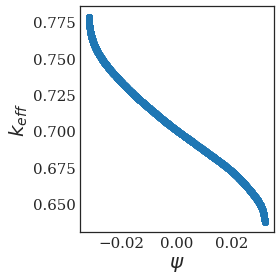

In [13]:
fig_compare_params = plt.figure(figsize = (4, 4))
for (k, lab) in enumerate([r"$k_{eff_1}$"]):
    ax = fig_compare_params.add_subplot(111)
    p = ax.scatter(phi1[:,1], exact_K1)
    ax.set_xlabel(r"$\psi$")
    ax.set_ylabel(r"$k_{{eff}}$")
plt.tight_layout()

## Subsystem Two keff

In [14]:
def midlevel_MEK_ERK_model2(x, t, k4, k5, k6):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
#     dS0  = -k1*x[0]*x[5] + k2*x[1]
#     dES0 =  k1*x[0]*x[5] - k2*x[1] - k3*x[1]
    dS1  =  -k4*x[0]*x[3] +k5*x[1]
    dES1 =  k4*x[0]*x[3] - k5*x[1] - k6*x[1]
    dS2  =  k6*x[1]
    dE   = -k4*x[0]*x[3]+ k5*x[1]  + k6*x[1]
    
    return [dS1,dES1, dS2, dE]

In [15]:
use_S2_only = True
generator = np.random.RandomState(2)

num_samples = 2000
num_steps = 6
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 12.5, num_steps + 1)
delta_k = 0.1 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size-1))
observations = np.zeros((num_samples, (1 if use_S2_only else 4)*num_steps-1)) # data to be used for DMaps
# Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.97, 7000 ,10000])
for i in tqdm.trange(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size -1)
    sol = odeint(midlevel_MEK_ERK_model2, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[2:,2]
    else:
        observations[i,:] = sol[1:,:].reshape(1,-1)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
Combined_Subsystem2 = np.c_[rate_constants, observations]

In [17]:
pw_dists = pdist(observations, "euclidean")
eps_par_red = 0.1*np.median(pw_dists**2) # scale parameter
dmap_par_red = diffusion_maps.SparseDiffusionMaps(points = observations,
                                                  epsilon = eps_par_red,
                                                  num_eigenpairs = 31,
                                                  cut_off = np.inf,  
                                                  renormalization = 1,
                                                  normalize_kernel = True)
phi2 = dmap_par_red.eigenvectors.T # dominant eigenvectors, including the trivial one

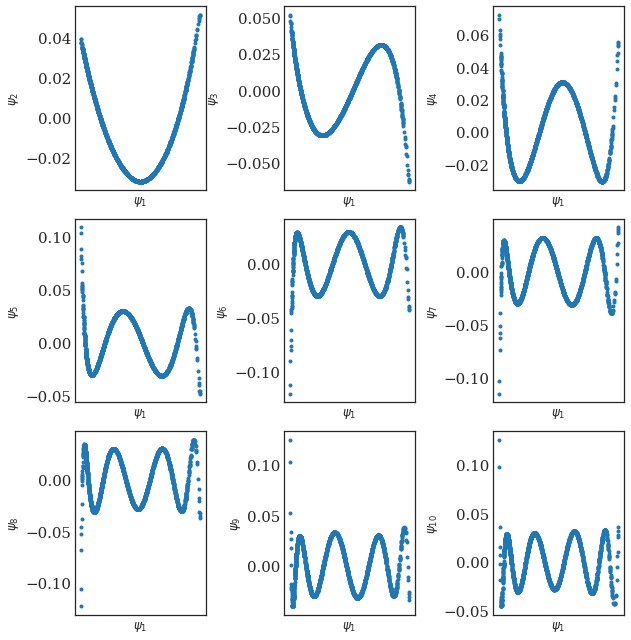

In [18]:
fig_dmaps_evecs = plt.figure(figsize = (3*3, 3*3));
for i in range (2,11):
    #fmt = "go" if i in indices else "bo"
    ax = fig_dmaps_evecs.add_subplot(3, 3, i-1)
    ax.plot(phi2[:,1], phi2[:,i], '.')
    ax.set_xlabel(r"$\psi_1$", fontsize = 12)
    ax.set_ylabel(r"$\psi_{%d}$" % i, fontsize = 12)
    ax.set_xticks([])
    ax.grid(False)
plt.tight_layout()

In [19]:
exact_K2 = rate_constants[:,0]*rate_constants[:,2]/(rate_constants[:,1] + rate_constants[:,2])

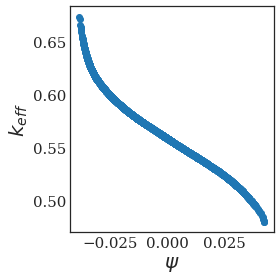

In [20]:
fig_compare_params = plt.figure(figsize = (4, 4))
for (k, lab) in enumerate([r"$k_{eff_1}$"]):
    ax = fig_compare_params.add_subplot(111)
    p = ax.scatter(phi2[:,1], exact_K2)
    #cs = plt.colorbar(p, ax = ax)
    #cs.set_label(lab)
    ax.set_xlabel(r"$\psi$")
    ax.set_ylabel(r"$k_{eff}$")
plt.tight_layout()